<h1>Six-Degrees of The NBA: Report</h1>

    By Will Hamilton, Mederick Grivel, Hooman Keshmiri, Benny Kotler, And Noah Ramey


    

In [1]:
import requests
import time
import pandas as pd 
import numpy as np
import datetime

# Introduction

For our presentation, we have decided to take on the concept of “Six Degrees of Kevin Bacon”, and apply it to the NBA to see how connected all of the current players are. Every edge in our graph of connections symbolizes two players having played on the same team at the same time. Our goal is to create a graphic visualization to obtain a collection of scenarios from the use of our data while analyzing the average length of connection between players.

In order to visualize this better, we created a web application that allows users to click on two nodes to find the shortest path between them, search up players based on name, and view clusters (which are composed of players that have similar connections to each other).

https://nowamey.github.io/nflsixdegrees_2022/webapp/

Something we'd like to note is that most of our code will not function here, as the project was built across multiple scripts for organizational purposes. All code for the webapp is in ./webapp and all code for data collection and processing can be found in ./nba_data_and_retrieval

# Retrieval and Preprocessing

To retrieve our data from the BasketAPI, We retrieved an authentication key from RapidAPI. The api holds many different categories of basketball data at an international scale, with players and teams referenced all by their own unique id


To get started with our data retrieval, we knew we needed to get a list of all of the active players and their unique ids from the API. Along with that, we needed to be able to connect player ids to some form of record of their history with teams. This resulted in us making two get requests. One the player data of every active player, in which we added all entries into a dataframe mapping id to name. The second get request was done once we had all of the player id’s, where we searched the transaction history for every player id. This gave us date ranges for every player's tenure with each team they have been with in their career. With this, we could build out our graph, making edges signifying that a pair of players were on the same team at the same time.

*One edge case we encountered was players who have never been traded. In this case, we had to search their current team with a different API call.*

With this date information, We converted the end and start dates to datetime objects to be properly compared with one another.




In [2]:
#The following code will request every single active player in the nba by searching through every current team.

def get_active_players():
    nba_ids =  {x for x in range(3409,3438)}
# New Orleans Pelicans are disjointed, presumably because of the name change
    nba_ids.add(5539)
    data =  pd.DataFrame(columns= ['id', 'name'])
    data.set_index('id',inplace=True)
    for teamid in range(3409,3438):
        time.sleep(2)
        url = f"https://basketapi1.p.rapidapi.com/api/basketball/team/{teamid}/players"

        headers = {
	        "X-RapidAPI-Key": "e0259fc1a8mshf3acbf6e3c99144p15e1edjsnb6ad953c45df",
	        "X-RapidAPI-Host": "basketapi1.p.rapidapi.com"
        }
        response = (requests.request("GET", url, headers=headers)).json()
        #can access all players. Need to build a local mapping of ids for the players as we get them. Then go ahead, grab transfer history per id!
        for player in response['players']:
            player_id = player['player']['id']
            player_name = player['player']['name']
            print(player_id,player_name)
            data.loc[player_id] = [player_name]
    
    data.to_csv('activeplayers_2023.csv')

In [5]:
HEADERS =  {
	        "X-RapidAPI-Key": "e0259fc1a8mshf3acbf6e3c99144p15e1edjsnb6ad953c45df",
	        "X-RapidAPI-Host": "basketapi1.p.rapidapi.com"
        }
def get_players_history(ids):
    #passed the index of the player dataframe, calls api to assemble a comprehensive df of trade history, and append it to the 
    #history dataframe
    data = pd.DataFrame(columns = ['player_id','player_name','team',"start","end"])
    for id in ids:
        try:
            data =  pd.concat([data,addtenures(id)])
        #rookies seem to have no transaction data, this was a workaround for that issue
        except ValueError:
            #incase of an id without trades, we will fill in history with just their current team
            url = f"https://basketapi1.p.rapidapi.com/api/basketball/player/{id}" 
            response = (requests.request("GET", url, headers=HEADERS)).json()
            row =  [id,response['player']['name'],response['player']['team']['name'],np.NaN,np.NaN]
            print(row)
            data.loc[id] = row
    data.to_csv('active_player_histories.csv')

def addtenures(player_id):
    # end --> NaN signifies current team
    df = pd.DataFrame(columns = ['player_id','player_name','team',"start","end"])
    #search tenures of the given player
    url = f"https://basketapi1.p.rapidapi.com/api/basketball/player/{player_id}/transfers"

    headers = {
	    "X-RapidAPI-Key": "e0259fc1a8mshf3acbf6e3c99144p15e1edjsnb6ad953c45df",
	    "X-RapidAPI-Host": "basketapi1.p.rapidapi.com"
    }
    try:
        response = (requests.request("GET", url, headers=headers)).json()
    except ValueError: 
        raise ValueError (f"No response for playerid {player_id}")
    hist = response['transferHistory']
    

    for i,trade in enumerate(hist):
        #current team - meaning no end date
        if(i == 0):
            row = [player_id,trade['player']['name'], trade['toTeamName'],datetime.date.fromtimestamp(trade['transferDateTimestamp']),np.NaN]
        #previous teams
        else:
            row = [player_id, trade['player']['name'], trade['toTeamName'],datetime.date.fromtimestamp(trade['transferDateTimestamp']),datetime.date.fromtimestamp(hist[i-1]['transferDateTimestamp'])]
        df.loc[len(df.index)] = row
    #terminal print to keep track of properly running requests
    return df


In [6]:
addtenures(817181)

,player_id,player_name,team,start,end
0,817181,LeBron James,Los Angeles Lakers,2018-06-30,NaN
1,817181,LeBron James,Cleveland Cavaliers,2014-06-24,2018-06-30
2,817181,LeBron James,Miami Heat,2010-07-09,2014-06-24
3,817181,LeBron James,Cleveland Cavaliers,2003-06-25,2010-07-09


Our complete datasets were made with only these methods. Above is an example output of the player tenures for star player LeBron James

# Visualization

We ran into a couple of issues with visualizing our data. As we started working, we realized that there are A LOT of connections in the NBA and using NetworkX or Gephi did not visualize our data well/would lag some of our machines. That being said, we really enjoyed the concept of this project and wanted to find better solutions. After doing some looking around, we found a library called Sigma.js, which would allow us to create graphs in a web application. This was a last hope to get this project visualized in a digestible manner, so we got to work.

First, we needed to convert all of our data that we collected in Python to something that could be used in JavaScript. We took our graph and converted it to a JSON file, where there were two keys: 'nodes' and 'edges'. Nodes are each player and edges are the connections between two players, which are determined by if two players have played on the same team together at some point. Something to consider is that while we had all of our data, we needed to manually position it ourselves. This almost became a dealbreaker until we realized that NetworkX, a Python library, had some built in functions to do this all for us. We used the function 'spring_layout' to determine the X and Y positions for nodes and then we applied a partitioning/clustering function to group elements by cluster.

Once we finally exported our data, it was very simple to use Sigma.js. A lot of the functionality makes sense. One problem we ran into was that modern versions of Sigma.js (3.0) lack the functionality that older versions have. We couldn't style our nodes/edges how we wanted and there wasn't very much documentation on it. After checking old builds and source code, we ended up reverting to an older version of the library. While not as performant, we could now style the graph how we wanted-- curved lines and edge colors determined by "source" node.

To find the closest path between two nodes, we used breadth-first search, as none of our edges are weighted and we lacked edge context to come up with any better solutions. This ended up being a great solution because BFS was very incredibly fast at finding the node paths we needed.

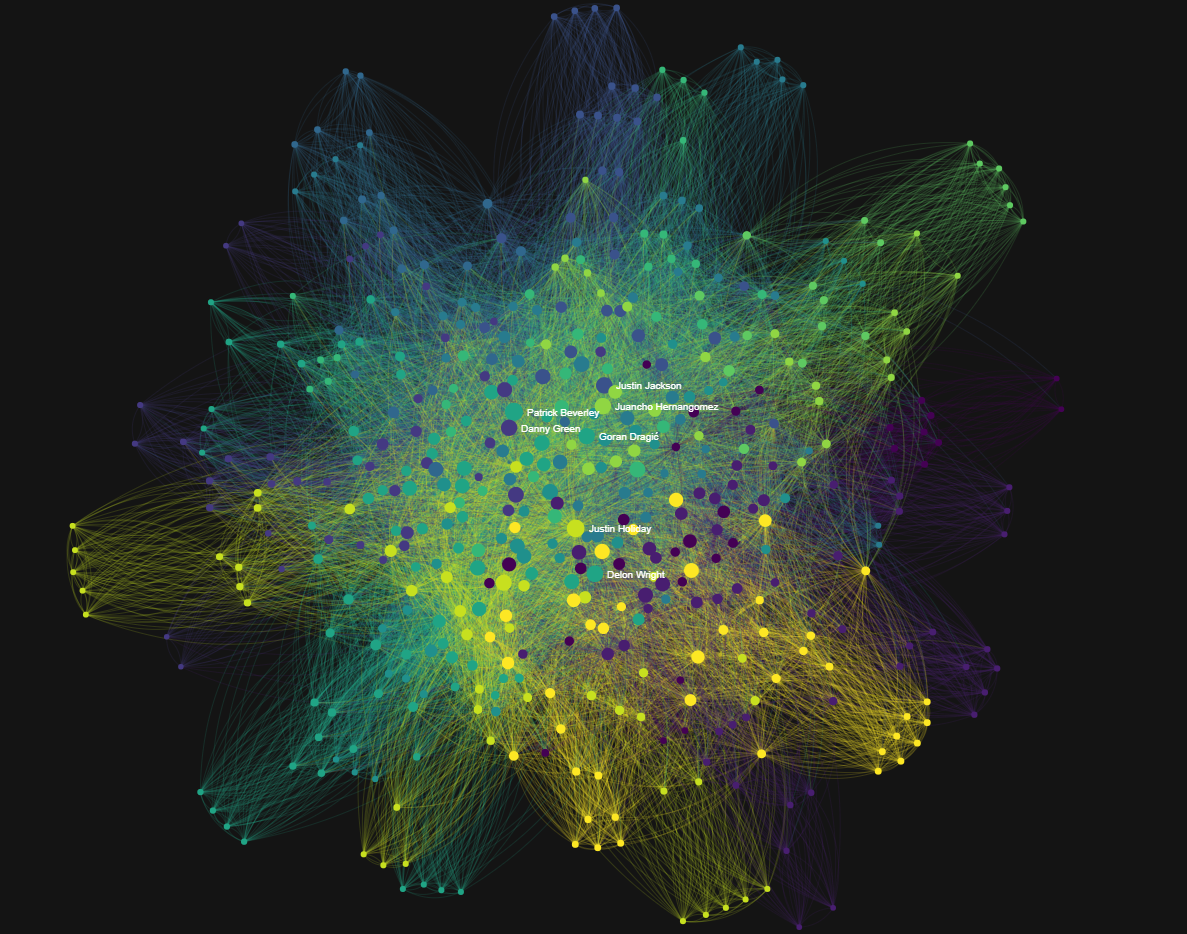

The code for exporting our graph from Python -> JSON can be found below.

In [ ]:
networkG = nx.Graph(graph.connections)
pos = nx.spring_layout(networkG, k=.2)
partition = best_partition(networkG)

# determine colors for each cluster
clusters = set(partition.values())
color_list = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
color_list = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255)) for r, g, b, _ in color_list]

cluster_color = { cluster: color_list[cluster] for cluster in clusters }

# final JSON output
output = { "edges": [], "nodes": [] }

max_edges = 0

# fill edges
for source, targets in graph.connections.items():
    max_edges = max(max_edges, len(targets))
    for target in targets:
        output["edges"].append({
            "source": source,
            "target": target,
            "line": "dotted"
        })


largest_node_size = 7.5

# fill nodess
for key, value in pos.items():
    cluster = partition[key]
    output["nodes"].append({
        "cluster": cluster,
        "color": cluster_color[cluster],
        "key": key,
        "id": key,
        "x": value[0],
        "y": value[1],
        "size": len(graph.connections[key])/max_edges * largest_node_size,
        "label": players[key]
    })

# output to a json file
import json

with open("../data.json", "w") as outfile:
    json.dump(output, outfile)

# Results

With the exception of players that spent time as a free agent or were out of the league and returned, the degrees of separation ended up working quite well. For example, if we take the players Donovan Mitchell and Lebron James they would be 2 degrees separated, with the mutual connection being George Hill who was on the Jazz with Mitchell in 2017 and at Cleveland in 2018

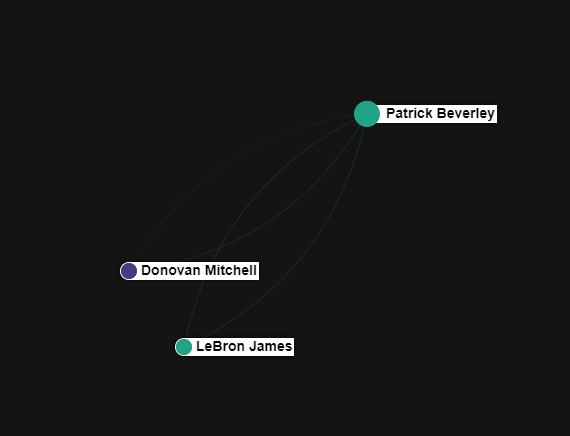

A longer example would be Trent Forrest to Moses Moody who are 4 degrees separated (the longest we found in the NBA). Forrest was on the Atlanta Hawks in 2022 at the same time as Skylar Mays. Skylar Mays was on the Atlanta Hawks with Justin Holiday towards the tail end of 2022. Justin Holiday shared a team (Golden State Warriors) with Andre Iguadala between 2014-2015. And finally, Moses Moody is currently on the Warriors with Andre Iguadala.

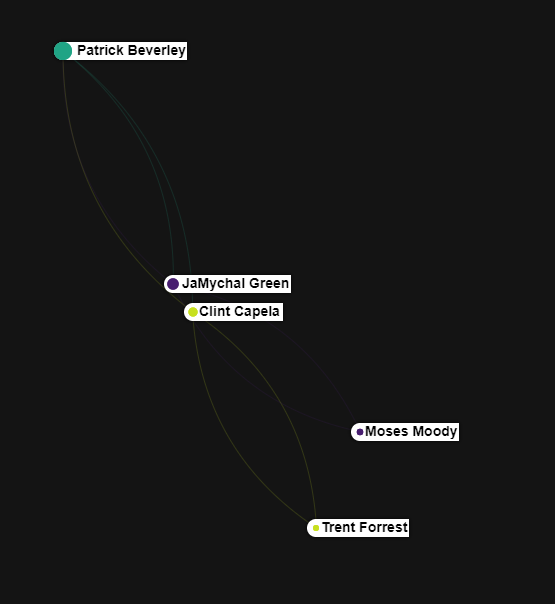

Further to most NBA fans it is easy to intuit which players will end up where in the graph. Generally a lot of the players that spent time on a lot of different teams and travel around find themselves in the center of the graph while rookies and other players who have been on fewer teams are on the edges, giving validity to our code.


# Discussion

The goal of our project was to find the closest path between two NBA players based on their former teams and teammates, similarly to Bacon’s Law. To create this, we made a graph that shows each of the connections in the NBA.

On this graph, the bigger the point is, the more connections that the player has. The graph shows that players such as Jeff Green, D.J. Augustin, and Justin Holiday have the biggest points, meaning that they have more connections. This would make sense because each of these three players have played for at least 11 teams meaning that they have had many different teammates throughout their careers.
We found that the most connections it would take between any two players is five. This proves that there is actually only 5 degrees of separation between any two players, proving Bacon’s Law of 6 degrees of separation. A point that can be made about the aforementioned longest example, both players are in their first couple years in the NBA, which limits the amount of teammates that they have played with, and makes it harder to find connections, making their degree of separation longer.

It would be interesting to look at this for other sports as well to determine what the maximum degrees of separation is in other pro leagues, and see if those other sports also have less than or equal to 6 degrees of separation at the maximum. 


# Limitations

The main limitation of this project is that we are only considering connections through active NBA players (as of 2023). This means we cannot search for connections between retired players and connections that exist between current and retired players are not considered in our analysis. The main reason for this was that our team decided that including retired player data would be too large of a dataset to wrangle. The active player dataset was already proving difficult for our team to visualize and adding players and edges to the graph was making our graph even harder to visualize. 

Another issue that arises with our data is the way the NBA handles its drafts. When a player is drafted to a team our dataset automatically assigns that player to the team, but oftentimes a team will trade a player immediately after drafting them. This means we have player data in our dataset that includes players who were on a team for only 1 day. Our team decided that this data would still be considered when finding a path because the player was still technically on the same team with other players albeit for 1 day.


# Conclusion

The conclusion of this project is that the concept of “Six Degrees of Kevin Bacon” applies within all active players in the NBA, in fact there are no connections between active players that exceed 4 degrees of separation. While our team expected to see many connections that fit within the 6 degrees, we were all surprised to find that it took less than 5 degrees to connect the entire NBA. There are many factors that contribute to this level of connectivity, firstly there are much less players on an NBA team which means a much smaller number of players to connect to one another, while the NFL has 1700 active players, our NBA dataset only has 501 active players. Another factor is that the NBA experiences multiple in-season trades that increase connectivity within the NBA, the more player trades -> the more edges in our graph -> the more connectivity between nodes. 

Finally, given the findings of our project, our team has decided to change the project title from “The Six Degrees of the NBA” to “The FIVE degrees of the NBA”.
